# Build Models to Predict Diabetic Patient Readmission_PySpark

This project is to review ML model building to predict readmission among diabetic patients using PySpark pipes

Credit: 
    - Codes used in this project are oroginally from:
        - https://github.com/omkarmutreja/Predicting-Re-admission-of-a-Diabetic-patient-using-PySpark
        - https://github.com/daniel-acuna/pyspark_pipes

## Content
1. Import required libraries
    - Standards libraries
    - Pyspark libraries
2. Initialize Spark Context
3. Load the diabetic data
4. Clean and Pre-process the data
5. Engineer features in the data
6. Build ML prediction models
    - Split Data into Training, Validation and Testing
    - Check correlation and select most significant features (for logistic regression)
    - Build Different Classification Models
        * Logistic Regression with Cross-Validation and Regularization
        * Random Forest with all features, Cross-Validation and Hyper-parameter tuning
        * Neural Networks with all features and one hidden layer with 8 neurons
        * Gradient Boosting with Cross-validation and Hyper-parameter tuning
    - Compare models' performances based on Accuracy and False Negatives
    - Test Gradient Boosting on test dataset
    - Inference and Results

7. Conclusion

## 1. Import required libraries

In [69]:
# Standards libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import decimal

# Pyspark libraries
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import regression
from pyspark.sql import functions as fn
from pyspark.sql.functions import countDistinct
from pyspark.sql import Row
from pyspark import sql
import seaborn as sns
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml import clustering
from pyspark.ml import classification
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve, auc
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

## 2. Initialize Spark Context

In [70]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## 3. Load the diabetic data

In [71]:
# Downloading the csv file 
df_spark = spark.read.csv("diabetic_data.csv",header=True)

## 4. Clean and Pre-process the data

### Removal of columns

In [72]:
# Removing Weight, Payer Code and Medical speciality of the surgeon as they have 80-90% missing values
drop_list = ['weight', 'payer_code','medical_specialty','citoglipton','examide']
df_spark = df_spark.select([column for column in df_spark.columns if column not in drop_list])

### Removal of rows

In [73]:
# Removing rows from Race,Discharge Disposition ID,Admission Source ID, Admission type ID
df_spark = df_spark.filter(df_spark.race!='?')
df_spark = df_spark.filter(df_spark.diag_1!='?')
df_spark = df_spark.filter(df_spark.diag_2!='?')
df_spark = df_spark.filter(df_spark.diag_3!='?')
df_spark = df_spark.filter(df_spark.discharge_disposition_id.isin(['11' '18','19','20','25'])==False)
df_spark = df_spark.filter(df_spark.admission_source_id.isin(['9','17','20'])==False)
df_spark = df_spark.filter(df_spark.admission_type_id.isin(['5','6','8'])==False)

### Changing Data Types

In [74]:
# Changing Data type of patient nbr and encounter_id to int
df_spark = df_spark.withColumn("patient_nbr", df_spark["patient_nbr"].cast(IntegerType()))
df_spark = df_spark.withColumn("encounter_id", df_spark["encounter_id"].cast(IntegerType()))

In [75]:
# Changing Data type of admission_type_id,discharge_disposition_id and all numerical columns to float
df_spark_clean1 = df_spark.select("encounter_id","patient_nbr",*(fn.col(c).cast("float").alias(c) for c in df_spark.columns 
                                 if c in ('admission_source_id','admission_type_id','discharge_disposition_id','time_in_hospital',
                                         'num_procedures','num_lab_procedures','num_medications','number_outpatient','number_emergency',
                                        'number_inpatient','number_diagnoses' )))

### Joining two dataframes

In [76]:
# Merging df_spark_clean and df_spark to get the entire cleaned dataset
drop_list = ['admission_type_id','discharge_disposition_id',
             'admission_source_id','time_in_hospital','num_lab_procedures',
             'num_procedures','num_medications','number_outpatient','number_emergency',
             'number_inpatient','number_diagnoses','patient_nbr']
diabetic_data_clean2 = df_spark.select([column for column in df_spark.columns if column not in drop_list])

df_spark = df_spark_clean1.join(diabetic_data_clean2, 'encounter_id', 'inner')

In [77]:
# Creating a temp file to query in future
df_spark.createOrReplaceTempView("temp") 

### Exploratory Data Analysis and further Data Manipulation

In [78]:
readmitted_count = df_spark.select('readmitted').groupBy('readmitted').count().show()
spark.sql("Select readmitted, count(readmitted),(count(readmitted)*100/(select count(readmitted) from temp)) as Percentage from temp group by readmitted").show()
# 11% of patients were readmitted within 30 days (<30)
# 35% of patients were readmitted after 30 days (>30)
# 54% of patients were never readmitted (NO)

+----------+-----+
|readmitted|count|
+----------+-----+
|       >30|30357|
|        NO|46654|
|       <30| 9850|
+----------+-----+

+----------+-----------------+------------------+
|readmitted|count(readmitted)|        Percentage|
+----------+-----------------+------------------+
|       >30|            30357| 34.94894141214124|
|        NO|            46654| 53.71110164515721|
|       <30|             9850|11.339956942701559|
+----------+-----------------+------------------+



Text(0, 0.5, 'Relative Frequency')

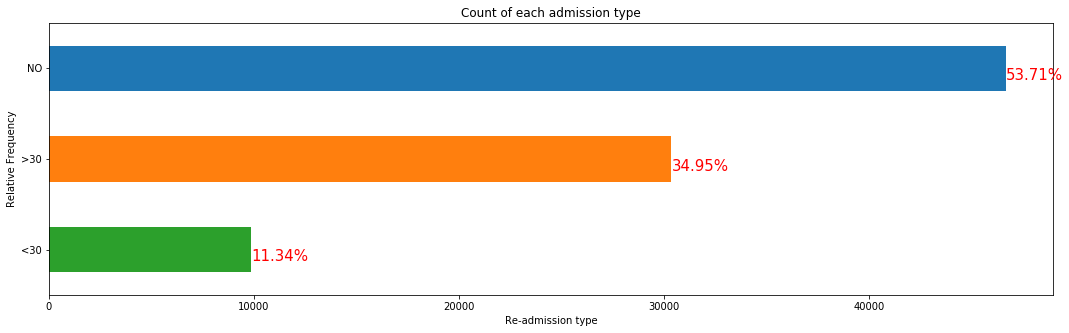

In [79]:
# The response variable 'readmitted' in the original dataset contains three categories.

a = df_spark.toPandas()
ax = a['readmitted'].value_counts().plot(kind='barh',figsize=(18,5),title="Count of each admission type")

totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='red')
ax.invert_yaxis()
ax.set_xlabel("Re-admission type")
ax.set_ylabel("Relative Frequency")

In [80]:
# Recode the readmission variable to 1 and 0 to find out correlation with predictor variables
# '0' means no readmission
# '1' means readmission no matter how many days after being discharged

df_spark = df_spark.withColumn('readmitted',fn.when(df_spark["readmitted"] == 'NO', 0).otherwise(1))
df_spark.createOrReplaceTempView("temp2") 

# We are keeping >30 and <30 days of re-admission as 1 as our scope of the project is to predict whether a patient
# will be re-admitted again or not after being diagosed with diabetes.

                    num_lab_procedures  num_procedures  num_medications  \
num_lab_procedures            1.000000        0.034882         0.276721   
num_procedures                0.034882        1.000000         0.382727   
num_medications               0.276721        0.382727         1.000000   
number_outpatient             0.021679       -0.021872         0.042476   
number_emergency              0.010894       -0.037808         0.012790   
number_inpatient              0.043331       -0.071090         0.063656   
number_diagnoses              0.162271        0.051944         0.240013   
readmitted                    0.028129       -0.047420         0.042582   

                    number_outpatient  number_emergency  number_inpatient  \
num_lab_procedures           0.021679          0.010894          0.043331   
num_procedures              -0.021872         -0.037808         -0.071090   
num_medications              0.042476          0.012790          0.063656   
number_outpatien

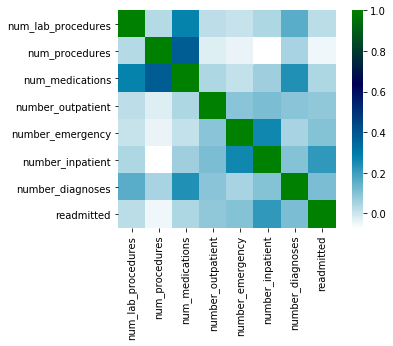

In [81]:
# Checking correlation among numerical variables and target variable readmitted
corr_matrix = df_spark.select('num_lab_procedures','num_procedures','num_medications','number_outpatient',
                              'number_emergency','number_inpatient','number_diagnoses','readmitted')

pd_corr = corr_matrix.toPandas()
print(pd_corr.corr())
sns.heatmap(pd_corr.corr(),square=True,cmap='ocean_r')

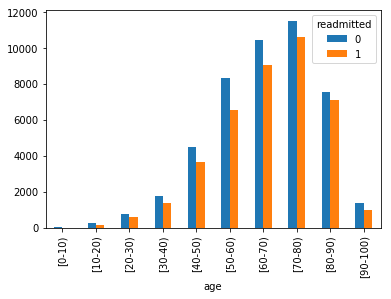

In [82]:
# Stacked Bar Graph with Age and Readmitted
df2 = df_spark.toPandas().groupby(['age', 'readmitted'])['age'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False)

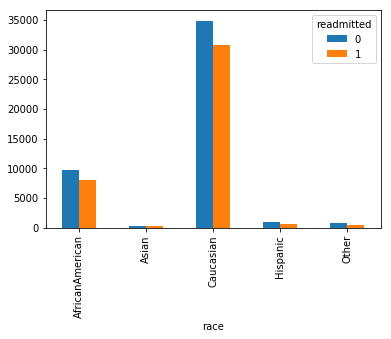

In [83]:
# Stacked Bar Graph with Race and Readmitted
df2 = df_spark.toPandas().groupby(['race', 'readmitted'])['race'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False)

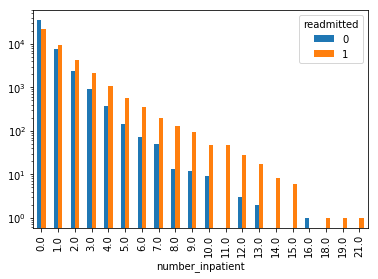

In [84]:
# Stacked Bar Graph with Inpatient and Readmitted
df2 = df_spark.toPandas().groupby(['number_inpatient', 'readmitted'])['number_inpatient'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False,logy=True)

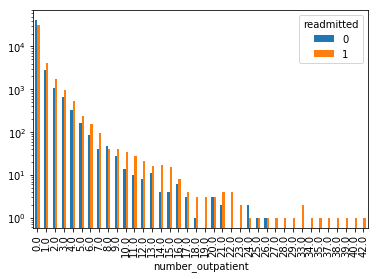

In [85]:
# Stacked Bar Graph with Outpatient and Readmitted
df2 = df_spark.toPandas().groupby(['number_outpatient', 'readmitted'])['number_outpatient'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False,logy=True)

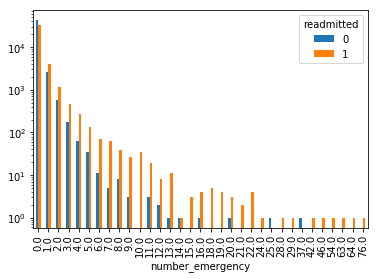

In [86]:
# Stacked Bar Graph with Emergency and Readmitted
df2 = df_spark.toPandas().groupby(['number_emergency', 'readmitted'])['number_emergency'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False,logy=True)

## 5. Engineer features in the data

In [87]:
## Creating new column total_visits = number_inpatient + number_outpatient
dfsum = fn.col('number_outpatient') + fn.col('number_inpatient')
df_spark = df_spark.withColumn('total_visits',dfsum)

### Create Dummy variables for nominal categorical columns

In [88]:
# Creating dummy variables for admission_type_id
df_spark = df_spark.withColumn('admission_type_emergency',fn.when(fn.col('admission_type_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_urgent',fn.when(fn.col('admission_type_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_elective',fn.when(fn.col('admission_type_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_trauma',fn.when(fn.col('admission_type_id')==7,1).otherwise(0))

#df_spark_final.select('admission_type_emergency','admission_type_urgent','admission_type_elective','admission_type_trauma').show(5)

In [89]:
# Creating dummy variables for discharge_disposition_id
df_spark = df_spark.withColumn('dd_home',fn.when(fn.col('discharge_disposition_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('dd_shortm_hos',fn.when(fn.col('discharge_disposition_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('dd_snf',fn.when(fn.col('discharge_disposition_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('dd_icf',fn.when(fn.col('discharge_disposition_id')==4,1).otherwise(0))
df_spark = df_spark.withColumn('dd_careInst',fn.when(fn.col('discharge_disposition_id')==5,1).otherwise(0))
df_spark = df_spark.withColumn('dd_hhs',fn.when(fn.col('discharge_disposition_id')==6,1).otherwise(0))
df_spark = df_spark.withColumn('dd_ama',fn.when(fn.col('discharge_disposition_id')==7,1).otherwise(0))
df_spark = df_spark.withColumn('dd_homeIvy',fn.when(fn.col('discharge_disposition_id')==8,1).otherwise(0))
df_spark = df_spark.withColumn('dd_admInp',fn.when(fn.col('discharge_disposition_id')==9,1).otherwise(0))
df_spark = df_spark.withColumn('dd_expired',fn.when(fn.col('discharge_disposition_id')==11,1).otherwise(0))
df_spark = df_spark.withColumn('dd_hospice',fn.when(fn.col('discharge_disposition_id')==13,1).otherwise(0))
df_spark = df_spark.withColumn('dd_medfac',fn.when(fn.col('discharge_disposition_id')==14,1).otherwise(0))
df_spark = df_spark.withColumn('dd_swingbed',fn.when(fn.col('discharge_disposition_id')==15,1).otherwise(0))
df_spark = df_spark.withColumn('dd_rehab',fn.when(fn.col('discharge_disposition_id')==22,1).otherwise(0))
df_spark = df_spark.withColumn('dd_long',fn.when(fn.col('discharge_disposition_id')==23,1).otherwise(0))
df_spark = df_spark.withColumn('dd_nursing',fn.when(fn.col('discharge_disposition_id')==24,1).otherwise(0))
df_spark = df_spark.withColumn('dd_federal',fn.when(fn.col('discharge_disposition_id')==27,1).otherwise(0))
df_spark = df_spark.withColumn('dd_psy',fn.when(fn.col('discharge_disposition_id')==28,1).otherwise(0))

In [90]:
# Creating dummy variables for admission_source_id
df_spark = df_spark.withColumn('admission_source_phyref',fn.when(fn.col('admission_source_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_cliref',fn.when(fn.col('admission_source_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hmoref',fn.when(fn.col('admission_source_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hos',fn.when(fn.col('admission_source_id')==4,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_snf',fn.when(fn.col('admission_source_id')==5,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hlthcare',fn.when(fn.col('admission_source_id')==6,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_emergency',fn.when(fn.col('admission_source_id')==7,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_court',fn.when(fn.col('admission_source_id')==8,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_critical',fn.when(fn.col('admission_source_id')==10,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_normdel',fn.when(fn.col('admission_source_id')==11,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_birth',fn.when(fn.col('admission_source_id')==14,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_surgery',fn.when(fn.col('admission_source_id')==25,1).otherwise(0))


In [91]:
# Creating dummy variables for race
df_spark = df_spark.withColumn('AfricanAmerican',fn.when(fn.col('race')=='AfricanAmerican',1).otherwise(0))
df_spark = df_spark.withColumn('Asian',fn.when(fn.col('race')=='Asian',1).otherwise(0))
df_spark = df_spark.withColumn('Caucasian',fn.when(fn.col('race')=='Caucasian',1).otherwise(0))
df_spark = df_spark.withColumn('Hispanic',fn.when(fn.col('race')=='Hispanic',1).otherwise(0))

# df_spark.select('AfricanAmerican','Asian','Caucasian','Hispanic','Other').show(5)

In [92]:
# Creating dummy variables for gender
df_spark = df_spark.withColumn('gender_male',fn.when(fn.col('gender')=='Male',1).otherwise(0))

In [93]:
# Grouped all the different types of diganosis based on their diag values specificed by the mapping document(ICD codes)
# Created dummy variables for each category

df_spark = df_spark.withColumn('diag1_Circulatory',
fn.when((df_spark['diag_1'] >= 390) & (df_spark['diag_1'] <= 459) | (df_spark['diag_1'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Respiratory',
fn.when((df_spark['diag_1'] >= 460) & (df_spark['diag_1'] <= 519) | (df_spark['diag_1'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Digestive',
fn.when((df_spark['diag_1'] >= 520) & (df_spark['diag_1'] <= 579) | (df_spark['diag_1'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag1_Diabetes', 
fn.when((df_spark['diag_1'] >= 250.00) & (df_spark['diag_1'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Injury', 
fn.when((df_spark['diag_1'] >= 800) & (df_spark['diag_1'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Musculoskeletal', 
fn.when((df_spark['diag_1'] >= 710) & (df_spark['diag_1'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Genitourinary',
fn.when((df_spark['diag_1'] >= 580) & (df_spark['diag_1'] <= 629) | (df_spark['diag_1'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag1_Neoplasms',
fn.when(((df_spark['diag_1'] >= 1) & (df_spark['diag_1'] <= 249)) | (df_spark['diag_1'] == 780) |
    (df_spark['diag_1'] == 781) | (df_spark['diag_1'] == 782) | (df_spark['diag_1'] == 784) |
        ((df_spark['diag_1'] >= 251) & (df_spark['diag_1'] <= 279)) | 
        ((df_spark['diag_1'] >= 680) & (df_spark['diag_1'] <= 709)) | 
        ((df_spark['diag_1'] >= 790) & (df_spark['diag_1'] <= 799)), 1).otherwise(0))


In [94]:
df_spark = df_spark.withColumn('diag2_Circulatory',
fn.when((df_spark['diag_2'] >= 390) & (df_spark['diag_2'] <= 459) | (df_spark['diag_2'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Respiratory',
fn.when((df_spark['diag_2'] >= 460) & (df_spark['diag_2'] <= 519) | (df_spark['diag_2'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Digestive',
fn.when((df_spark['diag_2'] >= 520) & (df_spark['diag_2'] <= 579) | (df_spark['diag_2'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag2_Diabetes', 
fn.when((df_spark['diag_2'] >= 250.00) & (df_spark['diag_2'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Injury', 
fn.when((df_spark['diag_2'] >= 800) & (df_spark['diag_2'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Musculoskeletal', 
fn.when((df_spark['diag_2'] >= 710) & (df_spark['diag_2'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Genitourinary',
fn.when((df_spark['diag_2'] >= 580) & (df_spark['diag_2'] <= 629) | (df_spark['diag_2'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag2_Neoplasms',
fn.when(((df_spark['diag_2'] >= 1) & (df_spark['diag_2'] <= 249)) | (df_spark['diag_2'] == 780) |
    (df_spark['diag_2'] == 781) | (df_spark['diag_2'] == 782) | (df_spark['diag_2'] == 784) |
        ((df_spark['diag_2'] >= 251) & (df_spark['diag_2'] <= 279)) | 
        ((df_spark['diag_2'] >= 680) & (df_spark['diag_2'] <= 709)) | 
        ((df_spark['diag_2'] >= 790) & (df_spark['diag_2'] <= 799)), 1).otherwise(0))


In [95]:
df_spark = df_spark.withColumn('diag3_Circulatory',
fn.when((df_spark['diag_3'] >= 390) & (df_spark['diag_3'] <= 459) | (df_spark['diag_3'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Respiratory',
fn.when((df_spark['diag_3'] >= 460) & (df_spark['diag_3'] <= 519) | (df_spark['diag_3'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Digestive',
fn.when((df_spark['diag_3'] >= 520) & (df_spark['diag_3'] <= 579) | (df_spark['diag_3'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag3_Diabetes', 
fn.when((df_spark['diag_3'] >= 250.00) & (df_spark['diag_3'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Injury', 
fn.when((df_spark['diag_3'] >= 800) & (df_spark['diag_3'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Musculoskeletal', 
fn.when((df_spark['diag_3'] >= 710) & (df_spark['diag_3'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Genitourinary',
fn.when((df_spark['diag_3'] >= 580) & (df_spark['diag_3'] <= 629) | (df_spark['diag_3'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag3_Neoplasms',
fn.when(((df_spark['diag_3'] >= 1) & (df_spark['diag_3'] <= 249)) | (df_spark['diag_3'] == 780) |
    (df_spark['diag_3'] == 781) | (df_spark['diag_3'] == 782) | (df_spark['diag_3'] == 784) |
        ((df_spark['diag_3'] >= 251) & (df_spark['diag_3'] <= 279)) | 
        ((df_spark['diag_3'] >= 680) & (df_spark['diag_3'] <= 709)) | 
        ((df_spark['diag_3'] >= 790) & (df_spark['diag_3'] <= 799)), 1).otherwise(0))


In [96]:
# Creating dummy variables for max_glu_serum
df_spark = df_spark.withColumn('max_glu_200',fn.when(fn.col('max_glu_serum')=='>200',1).otherwise(0))
df_spark = df_spark.withColumn('max_glu_300',fn.when(fn.col('max_glu_serum')=='>300',1).otherwise(0))
df_spark = df_spark.withColumn('max_glu_norm',fn.when(fn.col('max_glu_serum')=='Norm',1).otherwise(0))
#df_spark_final.select('max_glu_none','max_glu_200','max_glu_300','max_glu_norm').show(10)


In [97]:
# Creating dummy variables for A1Cresult
df_spark = df_spark.withColumn('A1Cresult_7',fn.when(fn.col('A1Cresult')=='>7',1).otherwise(0))
df_spark = df_spark.withColumn('A1Cresult_8',fn.when(fn.col('A1Cresult')=='>8',1).otherwise(0))
df_spark = df_spark.withColumn('A1Cresult_norm',fn.when(fn.col('A1Cresult')=='Norm',1).otherwise(0))
#df_spark_final.select('max_glu_none','max_glu_7','max_glu_8','max_glu_norm').show(10)

In [98]:
# Creating dummy variables for change and diabetesMed
df_spark = df_spark.withColumn('change',fn.when(fn.col('change')=='Ch',1).otherwise(0))
df_spark = df_spark.withColumn('diabetesMed',fn.when(fn.col('diabetesMed')=='Yes',1).otherwise(0))
#df_spark.select('change','diabetesMed').show(10)

### Treat all ordinal categorical columns by using String Indexer

In [99]:
# Converting all the 24 medicines
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('metformin','repaglinide','nateglinide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [100]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('chlorpropamide','glimepiride','acetohexamide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [101]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('miglitol','troglitazone','tolazamide')]


pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [102]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('insulin','glyburide-metformin','glipizide-metformin')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [103]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone')]


pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [104]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('glipizide','glyburide','tolbutamide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [105]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('pioglitazone','rosiglitazone','acarbose')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [106]:
df_spark = df_spark.withColumn('insulin_index1',fn.when(df_spark["insulin_index"]==2,4).\
                                           otherwise(df_spark["insulin_index"]))
df_spark = df_spark.withColumn('insulin_index1',fn.when(df_spark["insulin_index1"]==3,2).\
                                           otherwise(df_spark["insulin_index1"]))
df_spark = df_spark.drop('insulin_index')
df_spark = df_spark.withColumn('insulin_index',fn.when(df_spark["insulin_index1"]==4,3).\
                                           otherwise(df_spark["insulin_index1"]))
df_spark = df_spark.drop('insulin_index1')

In [107]:
df_spark = df_spark.withColumn('miglitol_index1',fn.when(df_spark["miglitol_index"]==2,4).\
                                           otherwise(df_spark["miglitol_index"]))
df_spark = df_spark.withColumn('miglitol_index1',fn.when(df_spark["miglitol_index1"]==3,2).\
                                           otherwise(df_spark["miglitol_index1"]))
df_spark = df_spark.drop('miglitol_index')
df_spark = df_spark.withColumn('miglitol_index',fn.when(df_spark["miglitol_index1"]==4,3).\
                                           otherwise(df_spark["miglitol_index1"]))
df_spark = df_spark.drop('miglitol_index1')

### Check data distributions and square root and log transform right-skewed ones

Text(0.5, 0, 'total_visits')

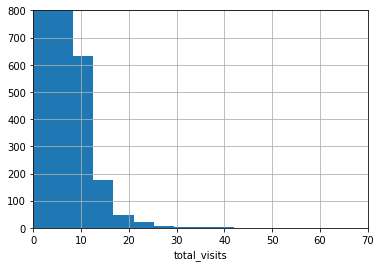

In [108]:
df_spark.select('total_visits').toPandas().total_visits.hist()
plt.xlim(0,70)
plt.ylim(0,800)
plt.xlabel('total_visits')
# Total visits is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5, 0, 'number_emergency')

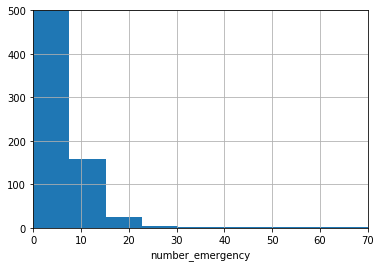

In [109]:
df_spark.select('number_emergency').toPandas().number_emergency.hist()
plt.xlim(0,70)
plt.ylim(0,500)
plt.xlabel('number_emergency')
# number_emergency is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5, 0, 'time_in_hospital')

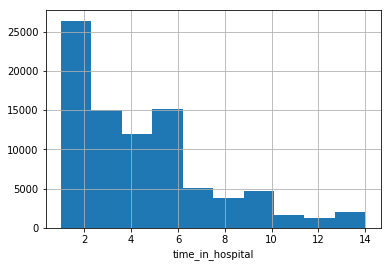

In [110]:
df_spark.select('time_in_hospital').toPandas().time_in_hospital.hist()
plt.xlabel('time_in_hospital')
# Time in hospital is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5, 0, 'num_lab_procedures')

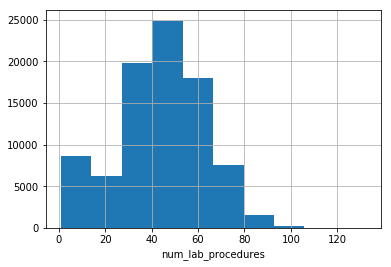

In [111]:
df_spark.select('num_lab_procedures').toPandas().num_lab_procedures.hist()
plt.xlabel('num_lab_procedures')
# num_lab_procedures is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5, 0, 'num_medications')

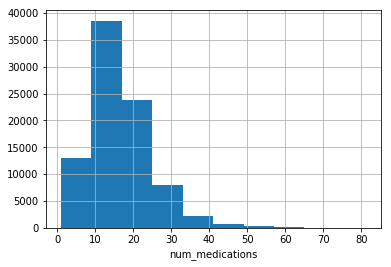

In [112]:
df_spark.select('num_medications').toPandas().num_medications.hist()
plt.xlabel('num_medications')
# num_medications is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5, 0, 'num_procedures')

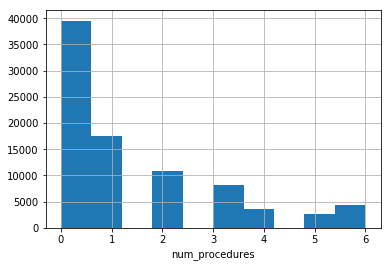

In [113]:
df_spark.select('num_procedures').toPandas().num_procedures.hist()
plt.xlabel('num_procedures')
# num_procedures is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5, 0, 'number_diagnoses')

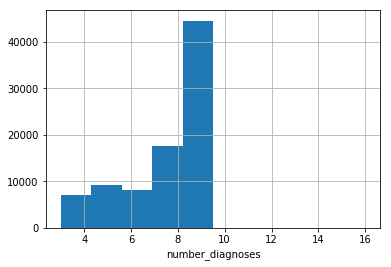

In [114]:
df_spark.select('number_diagnoses').toPandas().number_diagnoses.hist()
plt.xlabel('number_diagnoses')
# This is not a right-skewed and hence we do not take log of this

In [115]:
# Taking sqrt and log transformation both to see which performs better in modeling 

# SQRT Transformation
df_spark = df_spark.withColumn('total_visits_sqrt',fn.round(fn.sqrt(fn.col('total_visits')),2))
df_spark = df_spark.withColumn('number_emergency_sqrt',fn.round(fn.sqrt(fn.col('number_emergency')),2))
df_spark = df_spark.withColumn('num_lab_procedures_sqrt',fn.round(fn.sqrt(fn.col('num_lab_procedures')),2))
df_spark = df_spark.withColumn('num_medications_sqrt',fn.round(fn.sqrt(fn.col('num_medications')),2))

# LOG Transformation - Adding 0.01 as there are many 0 values
df_spark = df_spark.withColumn('total_visits_log',fn.round(fn.log(fn.col('total_visits')+0.01),2))
df_spark = df_spark.withColumn('number_emergency_log',fn.round(fn.log(fn.col('number_emergency')+0.01),2))
df_spark = df_spark.withColumn('num_lab_procedures_log',fn.round(fn.log(fn.col('num_lab_procedures')+0.01),2))
df_spark = df_spark.withColumn('num_medications_log',fn.round(fn.log(fn.col('num_medications')+0.01),2))
df_spark = df_spark.withColumn('time_in_hospital_log',fn.round(fn.log(fn.col('time_in_hospital')+0.01),2))
df_spark = df_spark.withColumn('num_procedures_log',fn.round(fn.log(fn.col('num_procedures')+0.01),2))




In [116]:
# Converting Age into numeric

df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[0-10)',10).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[10-20)',20).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[20-30)',30).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[30-40)',40).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[40-50)',50).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[50-60)',60).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[60-70)',70).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[70-80)',80).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[80-90)',90).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[90-100)',100).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[100-110)',110).otherwise(df_spark.age))


In [117]:
# Changing data type of age into Integer
df_spark = df_spark.withColumn("age", df_spark["age"].cast(IntegerType()))

Text(0.5, 0, 'age')

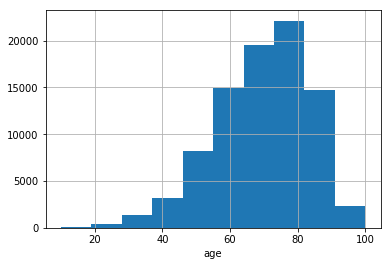

In [118]:
df_spark.select('age').toPandas().age.hist()
plt.xlabel('age')
# Left skewed

### Get only distinct patients with their first occurence

In [119]:
df_spark.createOrReplaceTempView("temp") 

In [120]:
unique_patient_df = spark.sql("select * from \
          (select patient_nbr, encounter_id,\
          row_number() over (partition by patient_nbr order by encounter_id) as rn \
  from temp \
  ) t \
where rn = 1")

In [121]:
# Converting scientific notation into full numeric number for encounter_id and patient_nbr in unique_patient df
unique_patient_df = unique_patient_df.withColumn('encounter_id', unique_patient_df.encounter_id.cast(DecimalType(15,0)))
unique_patient_df = unique_patient_df.withColumn('patient_nbr', unique_patient_df.patient_nbr.cast(DecimalType(15,0)))
unique_patient_df.select('encounter_id','patient_nbr').show(5)

+------------+-----------+
|encounter_id|patient_nbr|
+------------+-----------+
|    42462216|     113652|
|   100131384|     132318|
|    69445656|     244629|
|    26924070|     300825|
|    36236244|     308619|
+------------+-----------+
only showing top 5 rows



In [122]:
# Converting scientific notation into full numeric number for encounter_id and patient_nbr in df_spark df
df_spark = df_spark.withColumn('encounter_id', df_spark.encounter_id.cast(DecimalType(15,0)))
df_spark = df_spark.withColumn('patient_nbr', df_spark.patient_nbr.cast(DecimalType(15,0)))
df_spark.select('encounter_id','patient_nbr').show(10)

+------------+-----------+
|encounter_id|patient_nbr|
+------------+-----------+
|      149190|   55629189|
|       64410|   86047875|
|      500364|   82442376|
|       16680|   42519267|
|       35754|   82637451|
|       55842|   84259809|
|       63768|  114882984|
|       12522|   48330783|
|       15738|   63555939|
|       28236|   89869032|
+------------+-----------+
only showing top 10 rows



In [123]:
# Mergint the two datasets to get only distinct patient records (first occurence of their admission in the hospital)
df_spark_final  = df_spark.join(unique_patient_df, on=['encounter_id','patient_nbr'], how='inner')

In [124]:
# Taking backup of this df before performing modeling
backup_final = df_spark_final

## 6. Build ML prediction models

### Split Data into Training, Validation and Testing

In [125]:
training_df,validation_df,testing_df = df_spark_final.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  36465
# points in validation:  18232
# points in testing:  6038


In [126]:
# Checking if training_df split has equal proportion of readmitted patients
training_df.groupBy('readmitted').agg(fn.count('readmitted')).show()

+----------+-----------------+
|readmitted|count(readmitted)|
+----------+-----------------+
|         1|            14399|
|         0|            22066|
+----------+-----------------+



### Check correlation and select most significant features (for logistic regression)

In [127]:
training_df.select( 'dd_home','dd_shortm_hos', 'dd_snf', 'dd_icf','dd_careInst', 'dd_hhs','dd_ama',
 'dd_homeIvy','dd_admInp','dd_expired','dd_hospice','dd_medfac','dd_swingbed','dd_rehab',
 'dd_long','dd_nursing','dd_federal','dd_psy','readmitted').toPandas().corr()
# Only dd_hhs and dd_expired are highly correlated with readmitted

,dd_home,dd_shortm_hos,dd_snf,dd_icf,dd_careInst,dd_hhs,dd_ama,dd_homeIvy,dd_admInp,dd_expired,dd_hospice,dd_medfac,dd_swingbed,dd_rehab,dd_long,dd_nursing,dd_federal,dd_psy,readmitted
dd_home,1.000000,-0.187943,-0.474108,-0.118854,-0.148310,-0.472782,-0.101668,-0.042148,-0.013668,-0.166773,-0.083022,-0.063817,-0.029000,-0.190899,-0.082738,-0.028183,-0.009665,-0.038674,-0.019380
dd_shortm_hos,-0.187943,1.000000,-0.052325,-0.013117,-0.016368,-0.052179,-0.011221,-0.004652,-0.001508,-0.018406,-0.009163,-0.007043,-0.003201,-0.021069,-0.009131,-0.003110,-0.001067,-0.004268,0.010497
dd_snf,-0.474108,-0.052325,1.000000,-0.033090,-0.041291,-0.131627,-0.028305,-0.011734,-0.003805,-0.046431,-0.023114,-0.017767,-0.008074,-0.053148,-0.023035,-0.007846,-0.002691,-0.010767,0.027969
dd_icf,-0.118854,-0.013117,-0.033090,1.000000,-0.010351,-0.032997,-0.007096,-0.002942,-0.000954,-0.011640,-0.005794,-0.004454,-0.002024,-0.013324,-0.005775,-0.001967,-0.000675,-0.002699,0.009029
dd_careInst,-0.148310,-0.016368,-0.041291,-0.010351,1.000000,-0.041176,-0.008854,-0.003671,-0.001190,-0.014525,-0.007231,-0.005558,-0.002526,-0.016626,-0.007206,-0.002454,-0.000842,-0.003368,0.015692
dd_hhs,-0.472782,-0.052179,-0.131627,-0.032997,-0.041176,1.000000,-0.028226,-0.011702,-0.003795,-0.046301,-0.023050,-0.017718,-0.008051,-0.052999,-0.022971,-0.007824,-0.002683,-0.010737,0.047349
dd_ama,-0.101668,-0.011221,-0.028305,-0.007096,-0.008854,-0.028226,1.000000,-0.002516,-0.000816,-0.009957,-0.004957,-0.003810,-0.001731,-0.011397,-0.004940,-0.001683,-0.000577,-0.002309,0.004440
dd_homeIvy,-0.042148,-0.004652,-0.011734,-0.002942,-0.003671,-0.011702,-0.002516,1.000000,-0.000338,-0.004128,-0.002055,-0.001580,-0.000718,-0.004725,-0.002048,-0.000698,-0.000239,-0.000957,0.008685
dd_admInp,-0.013668,-0.001508,-0.003805,-0.000954,-0.001190,-0.003795,-0.000816,-0.000338,1.000000,-0.001339,-0.000666,-0.000512,-0.000233,-0.001532,-0.000664,-0.000226,-0.000078,-0.000310,-0.003104
dd_expired,-0.166773,-0.018406,-0.046431,-0.011640,-0.014525,-0.046301,-0.009957,-0.004128,-0.001339,1.000000,-0.008131,-0.006250,-0.002840,-0.018695,-0.008103,-0.002760,-0.000946,-0.003788,-0.103236


In [128]:
training_df.select( 'admission_source_phyref','admission_source_cliref',
 'admission_source_hmoref','admission_source_hos','admission_source_snf',
 'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
 'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','readmitted').toPandas().corr()
# Only admission_source_emergency is highly correlated

,admission_source_phyref,admission_source_cliref,admission_source_hmoref,admission_source_hos,admission_source_snf,admission_source_hlthcare,admission_source_emergency,admission_source_court,admission_source_critical,admission_source_normdel,admission_source_birth,admission_source_surgery,readmitted
admission_source_phyref,1.000000,-0.079814,-0.032467,-0.137763,-0.063531,-0.108170,-0.826069,-0.009476,-0.005065,NaN,NaN,-0.003581,-0.026297
admission_source_cliref,-0.079814,1.000000,-0.005541,-0.023510,-0.010842,-0.018460,-0.140971,-0.001617,-0.000864,NaN,NaN,-0.000611,-0.018266
admission_source_hmoref,-0.032467,-0.005541,1.000000,-0.009563,-0.004410,-0.007509,-0.057344,-0.000658,-0.000352,NaN,NaN,-0.000249,0.001919
admission_source_hos,-0.137763,-0.023510,-0.009563,1.000000,-0.018713,-0.031862,-0.243322,-0.002791,-0.001492,NaN,NaN,-0.001055,-0.048833
admission_source_snf,-0.063531,-0.010842,-0.004410,-0.018713,1.000000,-0.014694,-0.112212,-0.001287,-0.000688,NaN,NaN,-0.000486,-0.008040
admission_source_hlthcare,-0.108170,-0.018460,-0.007509,-0.031862,-0.014694,1.000000,-0.191054,-0.002192,-0.001171,NaN,NaN,-0.000828,-0.047058
admission_source_emergency,-0.826069,-0.140971,-0.057344,-0.243322,-0.112212,-0.191054,1.000000,-0.016737,-0.008946,NaN,NaN,-0.006326,0.064934
admission_source_court,-0.009476,-0.001617,-0.000658,-0.002791,-0.001287,-0.002192,-0.016737,1.000000,-0.000103,NaN,NaN,-0.000073,-0.007144
admission_source_critical,-0.005065,-0.000864,-0.000352,-0.001492,-0.000688,-0.001171,-0.008946,-0.000103,1.000000,NaN,NaN,-0.000039,0.001593
admission_source_normdel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
training_df.select('change','diabetesMed','age','readmitted').toPandas().corr()
# DiabetesMed and age are both significantly correlated with readmitted

,change,diabetesMed,age,readmitted
change,1.000000,0.510460,-0.041540,0.042863
diabetesMed,0.510460,1.000000,-0.018258,0.067572
age,-0.041540,-0.018258,1.000000,0.054428
readmitted,0.042863,0.067572,0.054428,1.000000


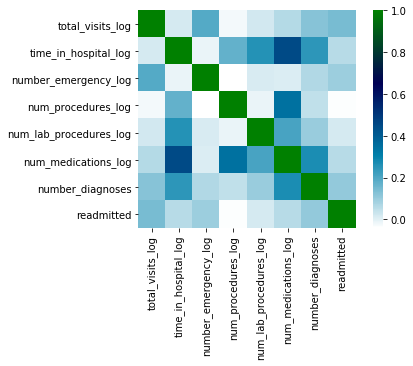

In [130]:
pd_corr = training_df.select('total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
                     'num_lab_procedures_log','num_medications_log','number_diagnoses','readmitted').toPandas()
sns.heatmap(pd_corr.corr(),square=True,cmap='ocean_r')
# All are somewhat correlated with readmitted

In [131]:
training_df.select('repaglinide_index',
 'nateglinide_index',
 'chlorpropamide_index','acetohexamide_index',
 'troglitazone_index',
 'tolazamide_index',
 'glyburide-metformin_index',
 'glipizide-metformin_index',
 'glimepiride-pioglitazone_index',
 'metformin-rosiglitazone_index',
 'metformin-pioglitazone_index',
 'tolbutamide_index',
 'pioglitazone_index','acarbose_index',
 'insulin_index','miglitol_index','readmitted').toPandas().corr()
# Only insulin_index is significantly correlated with readmitted 

,repaglinide_index,nateglinide_index,chlorpropamide_index,acetohexamide_index,troglitazone_index,tolazamide_index,glyburide-metformin_index,glipizide-metformin_index,glimepiride-pioglitazone_index,metformin-rosiglitazone_index,metformin-pioglitazone_index,tolbutamide_index,pioglitazone_index,acarbose_index,insulin_index,miglitol_index,readmitted
repaglinide_index,1.000000,0.001583,-0.003190,-0.000591,-0.000836,-0.002437,-0.005756,-0.001182,NaN,NaN,-0.000591,-0.001447,0.022982,0.027448,0.018487,0.018550,0.018150
nateglinide_index,0.001583,1.000000,-0.002465,-0.000456,-0.000646,-0.001883,-0.004547,-0.000913,NaN,NaN,-0.000456,-0.001118,0.038207,0.000546,0.004171,0.013822,0.007887
chlorpropamide_index,-0.003190,-0.002465,1.000000,-0.000148,-0.000209,-0.000611,-0.002454,-0.000296,NaN,NaN,-0.000148,-0.000363,-0.007702,-0.001432,-0.012726,-0.000513,0.000609
acetohexamide_index,-0.000591,-0.000456,-0.000148,1.000000,-0.000039,-0.000113,-0.000454,-0.000055,NaN,NaN,-0.000027,-0.000067,-0.001427,-0.000265,0.000928,-0.000095,0.006483
troglitazone_index,-0.000836,-0.000646,-0.000209,-0.000039,1.000000,-0.000160,-0.000643,-0.000078,NaN,NaN,-0.000039,-0.000095,-0.002018,-0.000375,0.008786,-0.000134,0.001593
tolazamide_index,-0.002437,-0.001883,-0.000611,-0.000113,-0.000160,1.000000,-0.001874,-0.000226,NaN,NaN,-0.000113,-0.000277,-0.001482,-0.001093,-0.011557,-0.000392,-0.001853
glyburide-metformin_index,-0.005756,-0.004547,-0.002454,-0.000454,-0.000643,-0.001874,1.000000,0.055650,NaN,NaN,-0.000454,-0.001113,0.027668,0.011380,0.010597,-0.001574,-0.001634
glipizide-metformin_index,-0.001182,-0.000913,-0.000296,-0.000055,-0.000078,-0.000226,0.055650,1.000000,NaN,NaN,-0.000055,-0.000134,-0.002853,-0.000530,0.001856,-0.000190,0.002253
glimepiride-pioglitazone_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metformin-rosiglitazone_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
training_df.select('diag1_Circulatory',
 'diag1_Respiratory',
 'diag1_Digestive',
 'diag1_Diabetes',
 'diag1_Injury',
 'diag1_Musculoskeletal',
 'diag1_Genitourinary',
 'diag1_Neoplasms',
 'diag2_Circulatory',
 'diag2_Respiratory',
 'diag2_Digestive',
 'diag2_Diabetes',
 'diag2_Injury',
 'diag2_Musculoskeletal',
 'diag2_Genitourinary',
 'diag2_Neoplasms',
 'diag3_Circulatory',
 'diag3_Respiratory',
 'diag3_Digestive',
 'diag3_Diabetes',
 'diag3_Injury',
 'diag3_Musculoskeletal',
 'diag3_Genitourinary',
 'diag3_Neoplasms','readmitted').toPandas().corr()
# None of the diagnosis is significantly correlated

,diag1_Circulatory,diag1_Respiratory,diag1_Digestive,diag1_Diabetes,diag1_Injury,diag1_Musculoskeletal,diag1_Genitourinary,diag1_Neoplasms,diag2_Circulatory,diag2_Respiratory,...,diag2_Neoplasms,diag3_Circulatory,diag3_Respiratory,diag3_Digestive,diag3_Diabetes,diag3_Injury,diag3_Musculoskeletal,diag3_Genitourinary,diag3_Neoplasms,readmitted
diag1_Circulatory,1.000000,-0.267289,-0.213074,-0.192994,-0.180409,-0.160187,-0.155148,-0.269726,0.310086,0.004083,...,-0.152114,0.172684,0.012987,-0.076862,0.020179,-0.027129,-0.050681,-0.023035,-0.087048,0.026538
diag1_Respiratory,-0.267289,1.000000,-0.127028,-0.115057,-0.107554,-0.095498,-0.092494,-0.160802,-0.005186,0.162598,...,-0.032944,0.016040,0.071775,-0.027054,0.025360,-0.036152,-0.013914,-0.022183,-0.013542,0.017092
diag1_Digestive,-0.213074,-0.127028,1.000000,-0.091719,-0.085739,-0.076128,-0.073734,-0.128186,-0.092842,-0.038709,...,-0.003510,-0.049292,-0.012936,0.162993,0.011750,-0.025347,-0.023675,-0.013752,-0.005330,-0.004855
diag1_Diabetes,-0.192994,-0.115057,-0.091719,1.000000,-0.077659,-0.068954,-0.066785,-0.116106,-0.062210,-0.040673,...,0.188850,-0.052228,-0.027300,0.008741,-0.112353,-0.013384,0.049983,0.008623,0.133628,0.020352
diag1_Injury,-0.180409,-0.107554,-0.085739,-0.077659,1.000000,-0.064457,-0.062430,-0.108535,-0.049642,-0.041749,...,-0.017651,-0.028294,-0.019895,-0.028162,-0.014202,0.129804,0.000604,-0.013237,-0.024867,-0.008161
diag1_Musculoskeletal,-0.160187,-0.095498,-0.076128,-0.068954,-0.064457,1.000000,-0.055432,-0.096369,-0.039834,-0.021318,...,-0.045316,-0.013762,-0.030262,-0.009820,0.053275,0.010697,0.108094,-0.025789,-0.028134,-0.022679
diag1_Genitourinary,-0.155148,-0.092494,-0.073734,-0.066785,-0.062430,-0.055432,1.000000,-0.093338,-0.071331,-0.036371,...,0.087512,-0.038514,-0.019846,-0.011716,-0.015679,-0.009515,-0.007795,0.096310,0.048748,-0.012672
diag1_Neoplasms,-0.269726,-0.160802,-0.128186,-0.116106,-0.108535,-0.096369,-0.093338,1.000000,-0.110072,-0.008054,...,0.089749,-0.065459,0.002132,0.016099,-0.002605,0.021731,-0.004302,0.036968,0.053630,-0.025299
diag2_Circulatory,0.310086,-0.005186,-0.092842,-0.062210,-0.049642,-0.039834,-0.071331,-0.110072,1.000000,-0.230295,...,-0.320131,0.099208,0.018354,-0.072908,0.091997,-0.024385,-0.042292,-0.010258,-0.084353,0.036300
diag2_Respiratory,0.004083,0.162598,-0.038709,-0.040673,-0.041749,-0.021318,-0.036371,-0.008054,-0.230295,1.000000,...,-0.158773,0.016385,0.069320,-0.017855,-0.005158,-0.007144,-0.008282,-0.006171,-0.013534,0.002584


### Build Different Classification Models

In [133]:
!pip install git+https://github.com/daniel-acuna/pyspark_pipes.git
from pyspark_pipes import pipe

  Cloning https://github.com/daniel-acuna/pyspark_pipes.git to c:\users\quynhle\appdata\local\temp\pip-req-build-8jrx806a
  Running setup.py bdist_wheel for pyspark-pipes: started
  Running setup.py bdist_wheel for pyspark-pipes: finished with status 'done'
  Stored in directory: C:\Users\quynhle\AppData\Local\Temp\pip-ephem-wheel-cache-xomp0uqp\wheels\58\e0\91\9f974ba72a9ea731a32cba0cccc17064e7d959a8f37e00263f
Successfully built pyspark-pipes


You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


#### Logistic Regression with Cross-Validation and Regularization

In [134]:
numerical_features = pipe(feature.VectorAssembler(inputCols=['time_in_hospital_log','number_emergency_log','total_visits_log',
                                        'num_medications_log','number_diagnoses','age']), feature.StandardScaler())

other_features = feature.VectorAssembler(inputCols=['dd_hhs','dd_expired','diabetesMed','insulin_index','admission_source_emergency'])

all_features = pipe((numerical_features, other_features), feature.VectorAssembler())
  
lr = classification.LogisticRegression(labelCol='readmitted')

final_model_pipeline = pipe(all_features, lr)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.1,0.01]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)


# Fitting the model on training_df
final_model_fitted = crossval.fit(training_df)

# Checking Validation_df accuracy
evaluator.evaluate(final_model_fitted.transform(validation_df))

0.635165054288365

In [135]:
# Checking the coefficients
final_model_fitted.bestModel.stages[-1].coefficients

DenseVector([0.0543, 0.1314, 0.2504, 0.0289, 0.14, 0.0869, 0.1044, -21.603, 0.253, 0.0147, 0.2412])

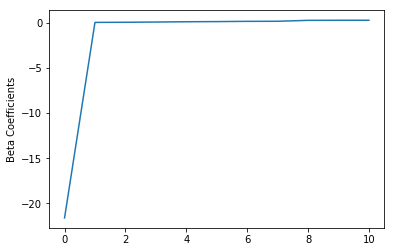

In [136]:
beta = np.sort(final_model_fitted.bestModel.stages[-1].coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [137]:
predictions_logistic = final_model_fitted.bestModel.transform(validation_df)

In [138]:
predictions_logistic = predictions_logistic.withColumn('rawPrediction',fn.col('LogisticRegression_480e82a03674cc091679__rawPrediction'))
predictions_logistic = predictions_logistic.withColumn('label',fn.col('readmitted'))


AnalysisException: "cannot resolve '`LogisticRegression_480e82a03674cc091679__rawPrediction`' given input columns: [troglitazone, A1Cresult, metformin-rosiglitazone, Asian, pioglitazone_index, dd_hhs, admission_source_hlthcare, diag2_Diabetes, dd_icf, diag1_Diabetes, num_lab_procedures_log, rosiglitazone_index, tolbutamide_index, admission_source_hos, num_lab_procedures_sqrt, A1Cresult_norm, VectorAssembler_631014ab5035__output, LogisticRegression_299e0d76ec13__rawPrediction, glipizide-metformin_index, VectorAssembler_185c86283253__output, glyburide-metformin, diag2_Injury, diag_1, VectorAssembler_df918cd6f13b__output, miglitol_index, LogisticRegression_299e0d76ec13__prediction, diag3_Circulatory, glimepiride, Hispanic, diag1_Musculoskeletal, dd_medfac, glipizide_index, acarbose_index, dd_hospice, StandardScaler_d41364c2b627__output, nateglinide, admission_type_elective, age, diag2_Neoplasms, admission_type_emergency, diag3_Genitourinary, admission_source_id, t.rn, dd_swingbed, diag1_Digestive, dd_rehab, time_in_hospital, num_medications_log, admission_source_normdel, metformin-pioglitazone, glipizide-metformin, max_glu_norm, dd_psy, dd_snf, pioglitazone, admission_source_cliref, num_medications, diag3_Musculoskeletal, number_inpatient, number_diagnoses, LogisticRegression_299e0d76ec13__probability, diabetesMed, glipizide, gender, total_visits_log, diag1_Respiratory, dd_nursing, dd_federal, A1Cresult_8, dd_careInst, dd_expired, miglitol, num_procedures_log, number_emergency_sqrt, Caucasian, repaglinide_index, max_glu_200, diag1_Genitourinary, metformin_index, admission_source_phyref, num_procedures, dd_home, AfricanAmerican, diag2_Genitourinary, admission_type_urgent, dd_shortm_hos, tolazamide_index, chlorpropamide_index, glyburide_index, num_lab_procedures, diag3_Injury, glimepiride-pioglitazone_index, max_glu_300, metformin-rosiglitazone_index, diag3_Diabetes, admission_source_surgery, acarbose, tolbutamide, glyburide, chlorpropamide, diag3_Respiratory, insulin_index, diag1_Injury, metformin-pioglitazone_index, diag2_Digestive, dd_ama, max_glu_serum, diag1_Circulatory, readmitted, admission_source_court, glyburide-metformin_index, diag_3, insulin, time_in_hospital_log, troglitazone_index, gender_male, admission_source_critical, admission_source_emergency, number_emergency, glimepiride_index, dd_homeIvy, num_medications_sqrt, dd_long, number_outpatient, rosiglitazone, diag2_Circulatory, encounter_id, total_visits, admission_source_hmoref, diag2_Respiratory, glimepiride-pioglitazone, discharge_disposition_id, repaglinide, nateglinide_index, dd_admInp, patient_nbr, diag_2, A1Cresult_7, acetohexamide, number_emergency_log, admission_source_birth, race, diag3_Digestive, change, metformin, diag1_Neoplasms, total_visits_sqrt, acetohexamide_index, admission_type_trauma, admission_type_id, tolazamide, diag3_Neoplasms, diag2_Musculoskeletal, admission_source_snf];;\n'Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 131 more fields]\n+- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 130 more fields]\n   +- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 129 more fields]\n      +- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 128 more fields]\n         +- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 127 more fields]\n            +- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 126 more fields]\n               +- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 125 more fields]\n                  +- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 124 more fields]\n                     +- Sample 0.6000000000000001, 0.9000000000000001, false, 0\n                        +- Sort [encounter_id#99040 ASC NULLS FIRST, patient_nbr#99187 ASC NULLS FIRST, admission_type_id#82290 ASC NULLS FIRST, discharge_disposition_id#82291 ASC NULLS FIRST, admission_source_id#82292 ASC NULLS FIRST, time_in_hospital#82293 ASC NULLS FIRST, num_lab_procedures#82294 ASC NULLS FIRST, num_procedures#82295 ASC NULLS FIRST, num_medications#82296 ASC NULLS FIRST, number_outpatient#82297 ASC NULLS FIRST, number_emergency#82298 ASC NULLS FIRST, number_inpatient#82299 ASC NULLS FIRST, number_diagnoses#82300 ASC NULLS FIRST, race#82055 ASC NULLS FIRST, gender#82056 ASC NULLS FIRST, age#98836 ASC NULLS FIRST, diag_1#82071 ASC NULLS FIRST, diag_2#82072 ASC NULLS FIRST, diag_3#82073 ASC NULLS FIRST, max_glu_serum#82075 ASC NULLS FIRST, A1Cresult#82076 ASC NULLS FIRST, metformin#82077 ASC NULLS FIRST, repaglinide#82078 ASC NULLS FIRST, nateglinide#82079 ASC NULLS FIRST, ... 123 more fields], false\n                           +- Project [encounter_id#99040, patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 123 more fields]\n                              +- Join Inner, ((encounter_id#99040 = encounter_id#99006) && (patient_nbr#99187 = patient_nbr#99010))\n                                 :- Project [encounter_id#99040, cast(patient_nbr#82198 as decimal(15,0)) AS patient_nbr#99187, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :  +- Project [cast(encounter_id#82244 as decimal(15,0)) AS encounter_id#99040, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, cast(age#98689 as int) AS age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98542 = [100-110)) THEN cast(110 as string) ELSE age#98542 END AS age#98689, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98395 = [90-100)) THEN cast(100 as string) ELSE age#98395 END AS age#98542, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98248 = [80-90)) THEN cast(90 as string) ELSE age#98248 END AS age#98395, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98101 = [70-80)) THEN cast(80 as string) ELSE age#98101 END AS age#98248, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97954 = [60-70)) THEN cast(70 as string) ELSE age#97954 END AS age#98101, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97807 = [50-60)) THEN cast(60 as string) ELSE age#97807 END AS age#97954, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97660 = [40-50)) THEN cast(50 as string) ELSE age#97660 END AS age#97807, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97513 = [30-40)) THEN cast(40 as string) ELSE age#97513 END AS age#97660, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97366 = [20-30)) THEN cast(30 as string) ELSE age#97366 END AS age#97513, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97219 = [10-20)) THEN cast(20 as string) ELSE age#97219 END AS age#97366, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#82057 = [0-10)) THEN cast(10 as string) ELSE age#82057 END AS age#97219, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                 :                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 121 more fields]\n                                 :                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 120 more fields]\n                                 :                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 119 more fields]\n                                 :                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 118 more fields]\n                                 :                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 117 more fields]\n                                 :                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 116 more fields]\n                                 :                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 115 more fields]\n                                 :                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 114 more fields]\n                                 :                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                 :                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                 :                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                 :                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                 :                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                 :                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                 :                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                 :                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                 :                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                 :                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                 :                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                 :                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                 :                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 111 more fields]\n                                 :                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 110 more fields]\n                                 :                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 109 more fields]\n                                 :                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 108 more fields]\n                                 :                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 107 more fields]\n                                 :                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 106 more fields]\n                                 :                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 105 more fields]\n                                 :                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 104 more fields]\n                                 :                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 103 more fields]\n                                 :                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 102 more fields]\n                                 :                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 101 more fields]\n                                 :                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 100 more fields]\n                                 :                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 99 more fields]\n                                 :                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 98 more fields]\n                                 :                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 97 more fields]\n                                 :                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 96 more fields]\n                                 :                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 95 more fields]\n                                 :                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 94 more fields]\n                                 :                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 93 more fields]\n                                 :                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 92 more fields]\n                                 :                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 91 more fields]\n                                 :                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 91 more fields]\n                                 :                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 91 more fields]\n                                 :                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 90 more fields]\n                                 :                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 89 more fields]\n                                 :                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 88 more fields]\n                                 :                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 87 more fields]\n                                 :                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 86 more fields]\n                                 :                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 85 more fields]\n                                 :                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 84 more fields]\n                                 :                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 83 more fields]\n                                 :                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 82 more fields]\n                                 :                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 81 more fields]\n                                 :                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 80 more fields]\n                                 :                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 79 more fields]\n                                 :                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 78 more fields]\n                                 :                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 77 more fields]\n                                 :                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 76 more fields]\n                                 :                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 75 more fields]\n                                 :                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 74 more fields]\n                                 :                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 73 more fields]\n                                 :                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 72 more fields]\n                                 :                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 71 more fields]\n                                 :                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 70 more fields]\n                                 :                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 69 more fields]\n                                 :                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 68 more fields]\n                                 :                                                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 67 more fields]\n                                 :                                                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 66 more fields]\n                                 :                                                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 65 more fields]\n                                 :                                                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 64 more fields]\n                                 :                                                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 63 more fields]\n                                 :                                                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 62 more fields]\n                                 :                                                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 61 more fields]\n                                 :                                                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 60 more fields]\n                                 :                                                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 59 more fields]\n                                 :                                                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 58 more fields]\n                                 :                                                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 57 more fields]\n                                 :                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 56 more fields]\n                                 :                                                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 55 more fields]\n                                 :                                                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 54 more fields]\n                                 :                                                                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 53 more fields]\n                                 :                                                                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 52 more fields]\n                                 :                                                                                                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 51 more fields]\n                                 :                                                                                                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 50 more fields]\n                                 :                                                                                                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 49 more fields]\n                                 :                                                                                                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 48 more fields]\n                                 :                                                                                                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 47 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 46 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 45 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 44 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 43 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 42 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 41 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 40 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 39 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 38 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 37 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 36 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 35 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 34 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 33 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 32 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 31 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 30 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 29 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 28 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 27 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 26 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 25 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 24 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 23 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 22 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                  +- Join Inner, (encounter_id#82244 = encounter_id#82347)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :- Project [encounter_id#82244, patient_nbr#82198, cast(admission_type_id#82059 as float) AS admission_type_id#82290, cast(discharge_disposition_id#82060 as float) AS discharge_disposition_id#82291, cast(admission_source_id#82061 as float) AS admission_source_id#82292, cast(time_in_hospital#82062 as float) AS time_in_hospital#82293, cast(num_lab_procedures#82065 as float) AS num_lab_procedures#82294, cast(num_procedures#82066 as float) AS num_procedures#82295, cast(num_medications#82067 as float) AS num_medications#82296, cast(number_outpatient#82068 as float) AS number_outpatient#82297, cast(number_emergency#82069 as float) AS number_emergency#82298, cast(number_inpatient#82070 as float) AS number_inpatient#82299, cast(number_diagnoses#82074 as float) AS number_diagnoses#82300]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :  +- Project [cast(encounter_id#82053 as int) AS encounter_id#82244, patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :     +- Project [encounter_id#82053, cast(patient_nbr#82054 as int) AS patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :        +- Filter (admission_type_id#82059 IN (5,6,8) = false)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :           +- Filter (admission_source_id#82061 IN (9,17,20) = false)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :              +- Filter (discharge_disposition_id#82060 IN (1118,19,20,25) = false)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :                 +- Filter NOT (diag_3#82073 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :                    +- Filter NOT (diag_2#82072 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :                       +- Filter NOT (diag_1#82071 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :                          +- Filter NOT (race#82055 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :                             +- Project [encounter_id#82053, patient_nbr#82054, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     :                                +- Relation[encounter_id#82053,patient_nbr#82054,race#82055,gender#82056,age#82057,weight#82058,admission_type_id#82059,discharge_disposition_id#82060,admission_source_id#82061,time_in_hospital#82062,payer_code#82063,medical_specialty#82064,num_lab_procedures#82065,num_procedures#82066,num_medications#82067,number_outpatient#82068,number_emergency#82069,number_inpatient#82070,diag_1#82071,diag_2#82072,diag_3#82073,number_diagnoses#82074,max_glu_serum#82075,A1Cresult#82076,... 26 more fields] csv\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [encounter_id#82347, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, chlorpropamide#82080, glimepiride#82081, acetohexamide#82082, glipizide#82083, glyburide#82084, tolbutamide#82085, pioglitazone#82086, rosiglitazone#82087, acarbose#82088, miglitol#82089, troglitazone#82090, tolazamide#82091, ... 9 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [cast(encounter_id#82053 as int) AS encounter_id#82347, patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [encounter_id#82053, cast(patient_nbr#82054 as int) AS patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                              +- Filter (admission_type_id#82059 IN (5,6,8) = false)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                 +- Filter (admission_source_id#82061 IN (9,17,20) = false)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                    +- Filter (discharge_disposition_id#82060 IN (1118,19,20,25) = false)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                       +- Filter NOT (diag_3#82073 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                          +- Filter NOT (diag_2#82072 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                             +- Filter NOT (diag_1#82071 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                                +- Filter NOT (race#82055 = ?)\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82053, patient_nbr#82054, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                 :                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Relation[encounter_id#82053,patient_nbr#82054,race#82055,gender#82056,age#82057,weight#82058,admission_type_id#82059,discharge_disposition_id#82060,admission_source_id#82061,time_in_hospital#82062,payer_code#82063,medical_specialty#82064,num_lab_procedures#82065,num_procedures#82066,num_medications#82067,number_outpatient#82068,number_emergency#82069,number_inpatient#82070,diag_1#82071,diag_2#82072,diag_3#82073,number_diagnoses#82074,max_glu_serum#82075,A1Cresult#82076,... 26 more fields] csv\n                                 +- Project [cast(patient_nbr#82198 as decimal(15,0)) AS patient_nbr#99010, encounter_id#99006, rn#99001]\n                                    +- Project [patient_nbr#82198, cast(encounter_id#82244 as decimal(15,0)) AS encounter_id#99006, rn#99001]\n                                       +- Project [patient_nbr#82198, encounter_id#82244, rn#99001]\n                                          +- Filter (rn#99001 = 1)\n                                             +- SubqueryAlias `t`\n                                                +- Project [patient_nbr#82198, encounter_id#82244, rn#99001]\n                                                   +- Project [patient_nbr#82198, encounter_id#82244, rn#99001, rn#99001]\n                                                      +- Window [row_number() windowspecdefinition(patient_nbr#82198, encounter_id#82244 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS rn#99001], [patient_nbr#82198], [encounter_id#82244 ASC NULLS FIRST]\n                                                         +- Project [patient_nbr#82198, encounter_id#82244]\n                                                            +- SubqueryAlias `temp`\n                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, cast(age#98689 as int) AS age#98836, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98542 = [100-110)) THEN cast(110 as string) ELSE age#98542 END AS age#98689, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98395 = [90-100)) THEN cast(100 as string) ELSE age#98395 END AS age#98542, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98248 = [80-90)) THEN cast(90 as string) ELSE age#98248 END AS age#98395, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#98101 = [70-80)) THEN cast(80 as string) ELSE age#98101 END AS age#98248, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97954 = [60-70)) THEN cast(70 as string) ELSE age#97954 END AS age#98101, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97807 = [50-60)) THEN cast(60 as string) ELSE age#97807 END AS age#97954, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97660 = [40-50)) THEN cast(50 as string) ELSE age#97660 END AS age#97807, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97513 = [30-40)) THEN cast(40 as string) ELSE age#97513 END AS age#97660, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97366 = [20-30)) THEN cast(30 as string) ELSE age#97366 END AS age#97513, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#97219 = [10-20)) THEN cast(20 as string) ELSE age#97219 END AS age#97366, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, CASE WHEN (age#82057 = [0-10)) THEN cast(10 as string) ELSE age#82057 END AS age#97219, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 122 more fields]\n                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 121 more fields]\n                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 120 more fields]\n                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 119 more fields]\n                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 118 more fields]\n                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 117 more fields]\n                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 116 more fields]\n                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 115 more fields]\n                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 114 more fields]\n                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 113 more fields]\n                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 112 more fields]\n                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 111 more fields]\n                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 110 more fields]\n                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 109 more fields]\n                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 108 more fields]\n                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 107 more fields]\n                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 106 more fields]\n                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 105 more fields]\n                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 104 more fields]\n                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 103 more fields]\n                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 102 more fields]\n                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 101 more fields]\n                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 100 more fields]\n                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 99 more fields]\n                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 98 more fields]\n                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 97 more fields]\n                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 96 more fields]\n                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 95 more fields]\n                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 94 more fields]\n                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 93 more fields]\n                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 92 more fields]\n                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 91 more fields]\n                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 91 more fields]\n                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 91 more fields]\n                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 90 more fields]\n                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 89 more fields]\n                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 88 more fields]\n                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 87 more fields]\n                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 86 more fields]\n                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 85 more fields]\n                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 84 more fields]\n                                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 83 more fields]\n                                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 82 more fields]\n                                                                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 81 more fields]\n                                                                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 80 more fields]\n                                                                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 79 more fields]\n                                                                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 78 more fields]\n                                                                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 77 more fields]\n                                                                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 76 more fields]\n                                                                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 75 more fields]\n                                                                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 74 more fields]\n                                                                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 73 more fields]\n                                                                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 72 more fields]\n                                                                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 71 more fields]\n                                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 70 more fields]\n                                                                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 69 more fields]\n                                                                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 68 more fields]\n                                                                                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 67 more fields]\n                                                                                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 66 more fields]\n                                                                                                                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 65 more fields]\n                                                                                                                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 64 more fields]\n                                                                                                                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 63 more fields]\n                                                                                                                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 62 more fields]\n                                                                                                                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 61 more fields]\n                                                                                                                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 60 more fields]\n                                                                                                                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 59 more fields]\n                                                                                                                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 58 more fields]\n                                                                                                                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 57 more fields]\n                                                                                                                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 56 more fields]\n                                                                                                                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 55 more fields]\n                                                                                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 54 more fields]\n                                                                                                                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 53 more fields]\n                                                                                                                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 52 more fields]\n                                                                                                                                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 51 more fields]\n                                                                                                                                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 50 more fields]\n                                                                                                                                                                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 49 more fields]\n                                                                                                                                                                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 48 more fields]\n                                                                                                                                                                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 47 more fields]\n                                                                                                                                                                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 46 more fields]\n                                                                                                                                                                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 45 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 44 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 43 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 42 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 41 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 40 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 39 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 38 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 37 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 36 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 35 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 34 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 33 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 32 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 31 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 30 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 29 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 28 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 27 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 26 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 25 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 24 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 23 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 22 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [encounter_id#82244, patient_nbr#82198, admission_type_id#82290, discharge_disposition_id#82291, admission_source_id#82292, time_in_hospital#82293, num_lab_procedures#82294, num_procedures#82295, num_medications#82296, number_outpatient#82297, number_emergency#82298, number_inpatient#82299, number_diagnoses#82300, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Join Inner, (encounter_id#82244 = encounter_id#82347)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :- Project [encounter_id#82244, patient_nbr#82198, cast(admission_type_id#82059 as float) AS admission_type_id#82290, cast(discharge_disposition_id#82060 as float) AS discharge_disposition_id#82291, cast(admission_source_id#82061 as float) AS admission_source_id#82292, cast(time_in_hospital#82062 as float) AS time_in_hospital#82293, cast(num_lab_procedures#82065 as float) AS num_lab_procedures#82294, cast(num_procedures#82066 as float) AS num_procedures#82295, cast(num_medications#82067 as float) AS num_medications#82296, cast(number_outpatient#82068 as float) AS number_outpatient#82297, cast(number_emergency#82069 as float) AS number_emergency#82298, cast(number_inpatient#82070 as float) AS number_inpatient#82299, cast(number_diagnoses#82074 as float) AS number_diagnoses#82300]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :  +- Project [cast(encounter_id#82053 as int) AS encounter_id#82244, patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :     +- Project [encounter_id#82053, cast(patient_nbr#82054 as int) AS patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :        +- Filter (admission_type_id#82059 IN (5,6,8) = false)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :           +- Filter (admission_source_id#82061 IN (9,17,20) = false)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :              +- Filter (discharge_disposition_id#82060 IN (1118,19,20,25) = false)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :                 +- Filter NOT (diag_3#82073 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :                    +- Filter NOT (diag_2#82072 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :                       +- Filter NOT (diag_1#82071 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :                          +- Filter NOT (race#82055 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :                             +- Project [encounter_id#82053, patient_nbr#82054, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               :                                +- Relation[encounter_id#82053,patient_nbr#82054,race#82055,gender#82056,age#82057,weight#82058,admission_type_id#82059,discharge_disposition_id#82060,admission_source_id#82061,time_in_hospital#82062,payer_code#82063,medical_specialty#82064,num_lab_procedures#82065,num_procedures#82066,num_medications#82067,number_outpatient#82068,number_emergency#82069,number_inpatient#82070,diag_1#82071,diag_2#82072,diag_3#82073,number_diagnoses#82074,max_glu_serum#82075,A1Cresult#82076,... 26 more fields] csv\n                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [encounter_id#82347, race#82055, gender#82056, age#82057, diag_1#82071, diag_2#82072, diag_3#82073, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, chlorpropamide#82080, glimepiride#82081, acetohexamide#82082, glipizide#82083, glyburide#82084, tolbutamide#82085, pioglitazone#82086, rosiglitazone#82087, acarbose#82088, miglitol#82089, troglitazone#82090, tolazamide#82091, ... 9 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [cast(encounter_id#82053 as int) AS encounter_id#82347, patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [encounter_id#82053, cast(patient_nbr#82054 as int) AS patient_nbr#82198, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Filter (admission_type_id#82059 IN (5,6,8) = false)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Filter (admission_source_id#82061 IN (9,17,20) = false)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Filter (discharge_disposition_id#82060 IN (1118,19,20,25) = false)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Filter NOT (diag_3#82073 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Filter NOT (diag_2#82072 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Filter NOT (diag_1#82071 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Filter NOT (race#82055 = ?)\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [encounter_id#82053, patient_nbr#82054, race#82055, gender#82056, age#82057, admission_type_id#82059, discharge_disposition_id#82060, admission_source_id#82061, time_in_hospital#82062, num_lab_procedures#82065, num_procedures#82066, num_medications#82067, number_outpatient#82068, number_emergency#82069, number_inpatient#82070, diag_1#82071, diag_2#82072, diag_3#82073, number_diagnoses#82074, max_glu_serum#82075, A1Cresult#82076, metformin#82077, repaglinide#82078, nateglinide#82079, ... 21 more fields]\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Relation[encounter_id#82053,patient_nbr#82054,race#82055,gender#82056,age#82057,weight#82058,admission_type_id#82059,discharge_disposition_id#82060,admission_source_id#82061,time_in_hospital#82062,payer_code#82063,medical_specialty#82064,num_lab_procedures#82065,num_procedures#82066,num_medications#82067,number_outpatient#82068,number_emergency#82069,number_inpatient#82070,diag_1#82071,diag_2#82072,diag_3#82073,number_diagnoses#82074,max_glu_serum#82075,A1Cresult#82076,... 26 more fields] csv\n"

In [ ]:
# Calculating Area under curve
evaluator = BinaryClassificationEvaluator()
print("Validation_df ROC: " + str(evaluator.evaluate(predictions_logistic, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
# Confusion matrix
tp = predictions_logistic[(predictions_logistic.label == 1) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 1)].count()
tn = predictions_logistic[(predictions_logistic.label == 0) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 0)].count()
fp = predictions_logistic[(predictions_logistic.label == 0) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 1)].count()
fn = predictions_logistic[(predictions_logistic.label == 1) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 0)].count()

In [ ]:
# Printing the confusion matrix
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

#### Random Forest with all features, Cross-Validation and Hyper-parameter tuning

In [ ]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'
                                        ])

all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

rf = classification.RandomForestClassifier(labelCol='readmitted',numTrees=10)

final_model_pipeline = pipe(all_features, rf)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100,200]) \
    .addGrid(rf.maxDepth, [4,6]) \
    .build()
crossval = CrossValidator(estimator=final_model_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=rf.getLabelCol(),rawPredictionCol=rf.getRawPredictionCol()),
                          numFolds=3) 

# Run cross-validation, and choose the best set of parameters.
cvModel_fitted = crossval.fit(training_df)

In [ ]:
predictions_rf = cvModel_fitted.transform(validation_df)
# predictions_rf.columns

In [ ]:
predictions_rf = predictions_rf.withColumn('rawPrediction',predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__rawPrediction)
predictions_rf = predictions_rf.withColumn('label',predictions_rf.readmitted)
evaluator = BinaryClassificationEvaluator()
print("Validation Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
# Confusion matrix
tp = predictions_rf[(predictions_rf.label == 1) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 1)].count()
tn = predictions_rf[(predictions_rf.label == 0) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 0)].count()
fp = predictions_rf[(predictions_rf.label == 0) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 1)].count()
fn = predictions_rf[(predictions_rf.label == 1) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 0)].count()

In [ ]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

In [ ]:
# Important features by random forest
rf_model = cvModel_fitted.bestModel.stages[-1]
feature_importance=pd.DataFrame(list(zip(['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'], rf_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance.head(10)

#### Neural Networks with all features and one hidden layer with 8 neurons

In [ ]:
# specify layers for the neural network:
# input layer of size 93 (features), one intermediate of size 8
# and output of size 2 (classes)
layers = [93,8,2]

In [ ]:
training_df = training_df.withColumn('label',training_df.readmitted)

va = feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','age',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'
                                        ], outputCol='features')


# create the trainer and set its parameters
neural = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

pipeline = Pipeline(stages=[va, neural])
model_neural = pipeline.fit(training_df)


In [ ]:
# Compute accuracy on the validation set
result_neural = model_neural.transform(validation_df)
result_neural = result_neural.withColumn('label',result_neural.readmitted)
predictionAndLabels = result_neural.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Validation set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

In [ ]:
# Confusion matrix
tp = result_neural[(result_neural.label == 1) & (result_neural.prediction == 1)].count()
tn = result_neural[(result_neural.label == 0) & (result_neural.prediction == 0)].count()
fp = result_neural[(result_neural.label == 0) & (result_neural.prediction == 1)].count()
fn = result_neural[(result_neural.label == 1) & (result_neural.prediction == 0)].count()


In [ ]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

#### Gradient Boosting with Cross-validation and Hyper-parameter tuning

In [ ]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'])

all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

gbt = GBTClassifier(labelCol='readmitted')

final_model_pipeline = pipe(all_features, gbt)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [4, 6]) \
    .addGrid(gbt.maxBins, [20, 40]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=final_model_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)



In [ ]:
cvModel_gbt = cv.fit(training_df)

In [ ]:
predictions_gbt2 = cvModel_gbt.transform(validation_df)

In [ ]:
predictions_gbt2 = predictions_gbt2.withColumn('label',predictions_gbt2.readmitted)

In [ ]:
evaluator.evaluate(predictions_gbt2)

In [ ]:
# Confusion matrix
tp = predictions_gbt2[(predictions_gbt2.label == 1) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
tn = predictions_gbt2[(predictions_gbt2.label == 0) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()
fp = predictions_gbt2[(predictions_gbt2.label == 0) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
fn = predictions_gbt2[(predictions_gbt2.label == 1) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()


In [ ]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

In [ ]:
# Important features by gradient boosting
gbt_model = cvModel_gbt.bestModel.stages[-1]
feature_importance=pd.DataFrame(list(zip(['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'], gbt_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance.head(10)

### Compare models' performances based on Accuracy and False Negatives

In [ ]:
# As this is a health care domain, we compare our models based on False Negatives and accuracy.
# The model with the least FN and highest accuracy is the best model in our case.

model_comparison_df = pd.DataFrame({'Model_name': ['Logistic Regression', 'Random Forest',
                                                 'Neural Network','Gradient Boosting'],
                                   'Validation_Accuracy': [63.52, 64.59,61.83,64.89],
                                   'False_Negatives': [5600,6895,6147,5309]})

plt.plot(model_comparison_df.Model_name,model_comparison_df.Validation_Accuracy,'-o')
plt.xlabel('Model Name')
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison based on Accuracy')

In [ ]:
plt.plot(model_comparison_df.Model_name,model_comparison_df.False_Negatives,'-or')
plt.xlabel('Model Name')
plt.ylabel('False Negatives')
plt.title('Model Comparison based on False Negatives')

Note: The graphs show that Gradient Boosting has the maximum accuracy on Validation set and least False Negatives

### Test Gradient Boosting on test dataset

In [ ]:
predictions_gbt2_test = cvModel_gbt.transform(testing_df)
predictions_gbt2_test = predictions_gbt2_test.withColumn('prediction',predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction)

predictions_gbt2_test = predictions_gbt2_test.withColumn('label',predictions_gbt2_test.readmitted)
evaluator.evaluate(predictions_gbt2_test)

In [ ]:
# Confusion matrix
tp = predictions_gbt2_test[(predictions_gbt2_test.label == 1) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
tn = predictions_gbt2_test[(predictions_gbt2_test.label == 0) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()
fp = predictions_gbt2_test[(predictions_gbt2_test.label == 0) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
fn = predictions_gbt2_test[(predictions_gbt2_test.label == 1) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()


In [ ]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

In [ ]:
# Plotting the test set confusion matrix
array = [[3084,513],
     [1759,682]]        
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap='YlGnBu',fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [ ]:
# True-positive rate, False-positive rate and AUC
x = 3084/(1759+3084)
y = 682/(682+513)

AUC = (3084/(2*(1759+3084))) + (682/(2*(682+513)))


print("TP:",x)
print("FP:",y)
print("AUC:",AUC)

In [ ]:
# Plotting the test set ROC and AUC
predictions_gbt2_test_df = predictions_gbt2_test.toPandas()
predictions_test = predictions_gbt2_test_df['prediction']
outcome_test = predictions_gbt2_test_df['label']
fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkturquoise', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(b=False)
plt.show()

### Inference and Results

In [ ]:
# As total number of visits and emergency visits increases, the chances of getting re-admitted increases
# With increasing number of diagnoses and medications, the patient has a higher chance of getting re-admitted
# As people get older,they have a higher chance of re-admission
# A patient who stays for a longer duration in hospital has a higher chance of re-admission
# A patient who has discharge dispositon id as hospice or medfac has a higher chance of getting re-admitted

## 7. Conclusion

In [ ]:
# Gradient Boosting performed the best in terms of accuracy and number of false negatives
# and also fits the testing data well